In [1]:
import csv
import numpy as np

time = []
discharge = []
temperature = []
conductance = []

with open('data/HotCreekData.tsv','r') as f:
    hcreader = csv.reader(f, delimiter = '\t', skipinitialspace = True)
    for _ in range(33):
        next(hcreader)
    for line in hcreader:
        time += [np.datetime64(line[2])]
        try:
            discharge += [np.float64(line[4])]
        except:
            discharge += [np.nan]
            
        try:
            temperature += [np.float64(line[6])]
        except:
            temperature += [np.nan]
            
        try:
            conductance += [np.float64(line[8])]
        except:
            conductance += [np.nan]

time = np.array(time)
discharge = np.array(discharge)
temperature = np.array(temperature)
conductance = np.array(conductance)

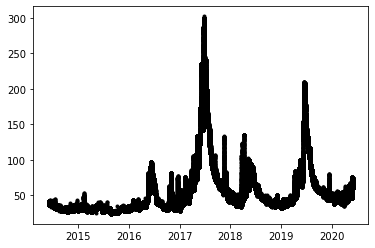

In [2]:
import matplotlib.pylab as plt

plt.plot(time, discharge, 'k.')

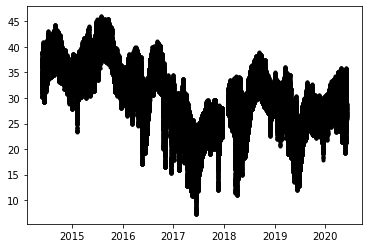

In [3]:
plt.plot(time, temperature, 'k.')

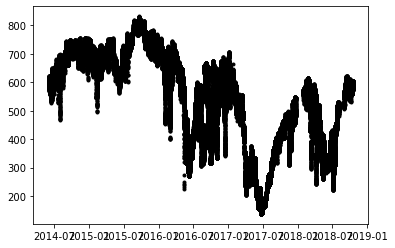

In [4]:
plt.plot(time, conductance, 'k.')

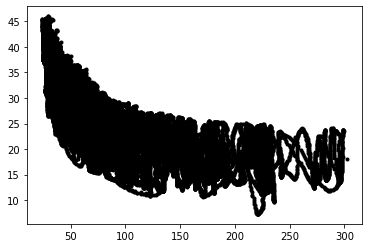

In [5]:
plt.plot(discharge,temperature, 'k.')

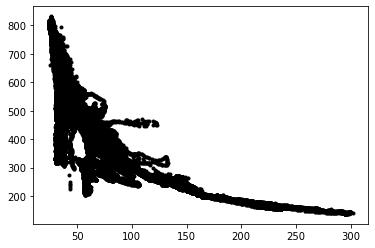

In [6]:
plt.plot(discharge, conductance, 'k.')

/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


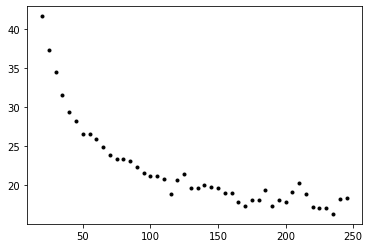

In [7]:
# High discharge conditions seem to have constant temperature, meaning that temperatures are dominated by creek, not hydrothermal system.  Creek temperature might be estimated as:

for lower_limit in np.arange(0, 250, 5):
    upper_limit = lower_limit + 5
    i = np.where(np.logical_and(discharge >= lower_limit, discharge <= upper_limit))
    plt.plot(lower_limit, np.nanmean(temperature[i]), 'k.')


In [8]:
i = np.where(discharge > 180.0)
print(np.nanmean(temperature[i]))

18.036819516602666


/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


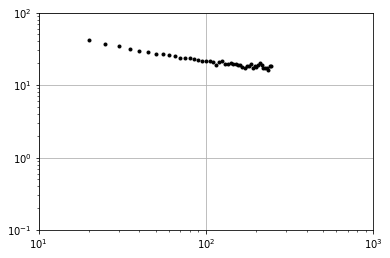

In [9]:
for lower_limit in np.arange(0, 250, 5):
    upper_limit = lower_limit + 5
    i = np.where(np.logical_and(discharge >= lower_limit, discharge <= upper_limit))
    plt.loglog(lower_limit, np.nanmean(temperature[i]), 'k.')
plt.xlim([10, 1000])
plt.ylim([0.1, 100])
plt.grid()

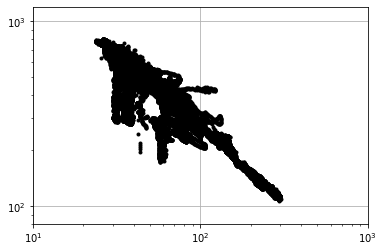

In [10]:
plt.loglog(discharge, conductance - 30.0, 'k.')
plt.xlim([10, 1000])
plt.ylim([80, 1200])
plt.grid()

In [11]:
from numpy.linalg import inv

i = np.where(np.logical_and(np.logical_and(~np.isnan(discharge),~np.isnan(conductance)), conductance > 30.0))

G = np.ones((len(i[0]), 1))

d = np.log10(conductance[i].T - 30.0) + np.log10(discharge[i].T)

m = np.matmul(np.matmul(inv(np.matmul(G.T,G)),G.T),d)

In [12]:
print('Discharge * Conductance of geothermal fluids is: ', np.power(10,m[0]), m)

Discharge * Conductance of geothermal fluids is:  21817.55196768556 [4.33880602]


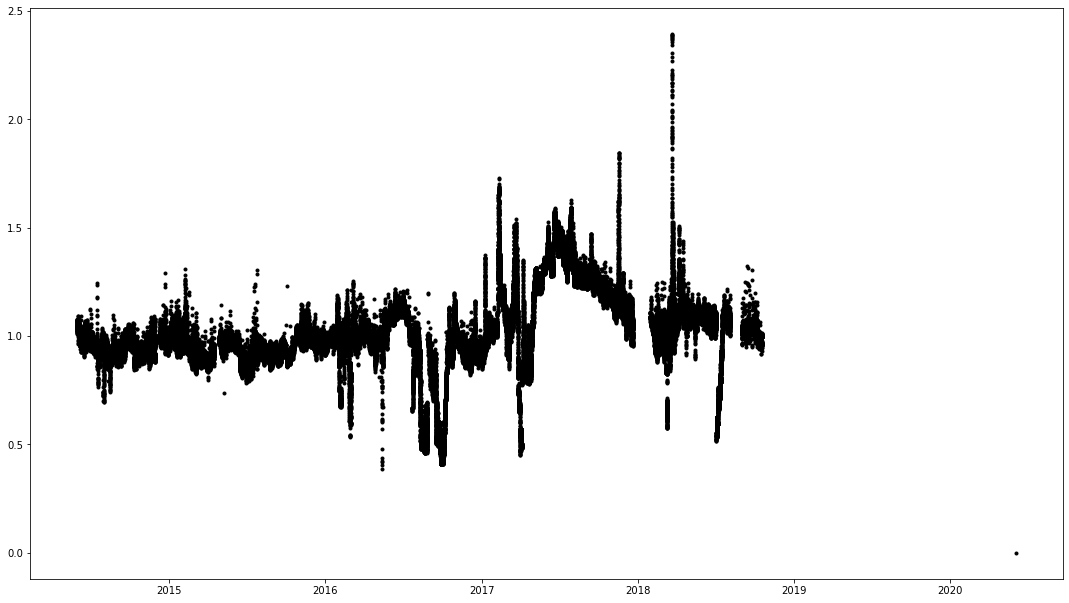

In [13]:
# Unmix mean geothermal signature from time-series:

Ceff = np.power(10,np.log10(conductance - 30.0) + np.log10(discharge) - m[0])
Ceff[-1] = 0.0
plt.plot(time, Ceff, 'k.')
plt.gcf().set_size_inches(18.5, 10.5)

In [14]:
from numpy.linalg import inv

i = np.where(np.logical_and(np.logical_and(~np.isnan(discharge),~np.isnan(temperature)), temperature > 18.0))

G = np.ones((len(i[0]), 1))

d = np.log10(temperature[i].T - 18.0) + np.log10(discharge[i].T)

m = np.matmul(np.matmul(inv(np.matmul(G.T,G)),G.T),d)

In [15]:
print('Discharge * Temperature of geothermal fluids is: ', np.power(10,m))

Discharge * Temperature of geothermal fluids is:  [470.64679033]


/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


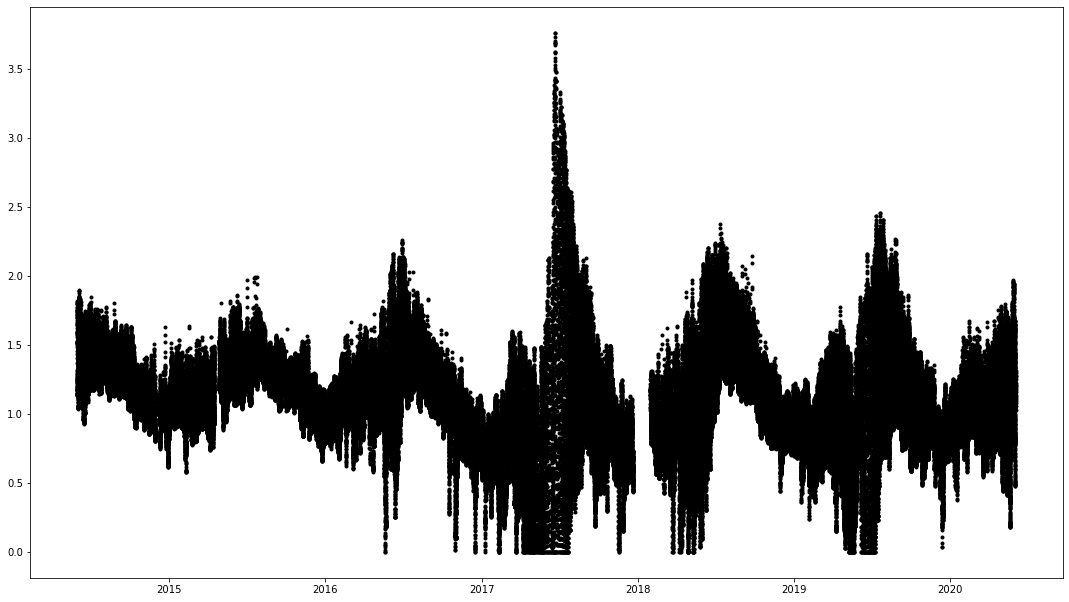

In [16]:
# Unmix mean geothermal signature from time-series:

Teff = np.power(10,np.log10(temperature - 18.0) + np.log10(discharge) - m)

plt.plot(time, Teff, 'k.')
plt.gcf().set_size_inches(18.5, 10.5)

In [17]:
# Need to filter out seasonal water-temperature changes:

def periodic_signal(t, wl):
    
    t_days = (t-min(t)).astype('timedelta64[s]').astype(np.float64)/(60.0*60.0*24.0)
    
    def inner_function(x):
        (A1, A2, offset) = x
        return A1 * np.cos(2.0*np.pi*t_days/wl) + A2 * np.sin(2.0*np.pi*t_days/wl) + offset
    
    return inner_function

def misfit(t, Teff, wl):
    
    model = periodic_signal(t, wl)
    
    def inner_function(x):
        return np.sum(np.power(model(x) - Teff, 2))
    
    return inner_function

In [18]:
from scipy.optimize import fmin

i = np.where(~np.isnan(Teff))

x0 = np.array([0.5, 0.0, 1.0])

x = fmin(misfit(time[i], Teff[i], 365.0), x0)


Optimization terminated successfully.
         Current function value: 19919.678080
         Iterations: 125
         Function evaluations: 215


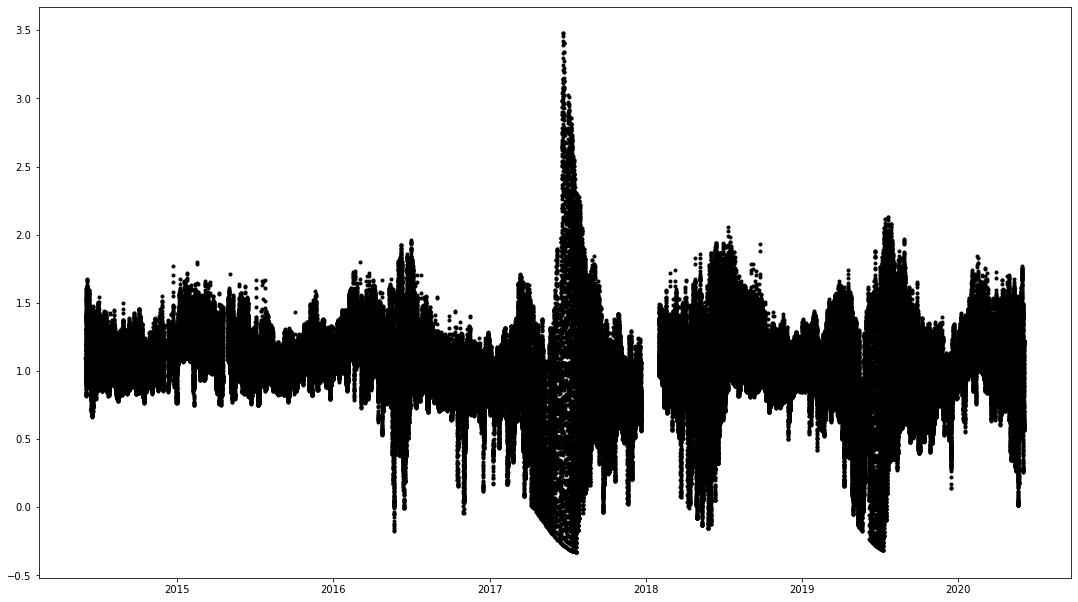

In [19]:
signal = periodic_signal(time, 365.0)

Tresid = Teff - signal(x)

plt.plot(time, Tresid+1.0, 'k.')
plt.gcf().set_size_inches(18.5, 10.5)

/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


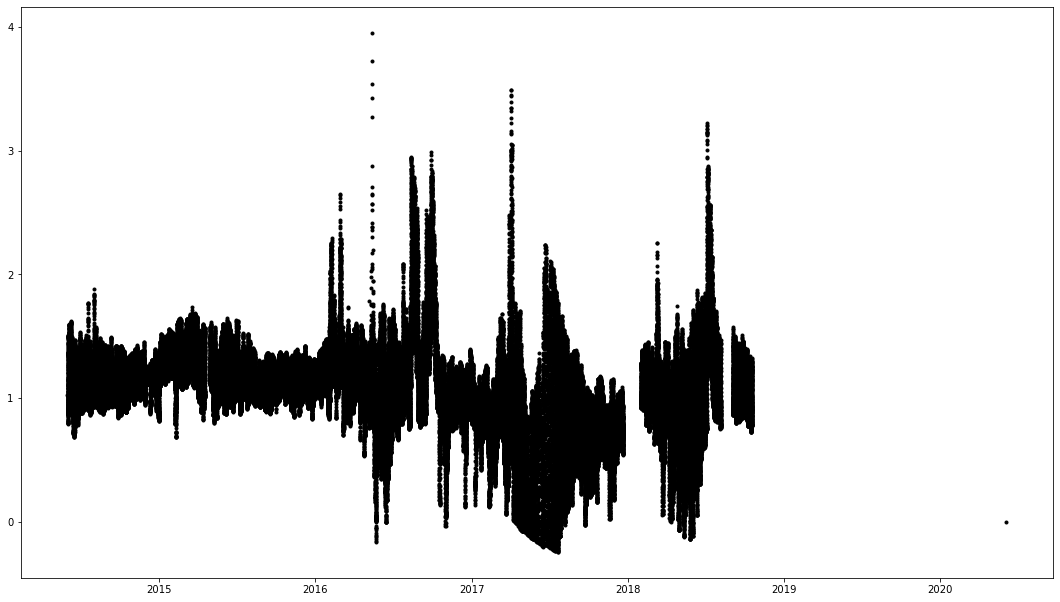

In [20]:
r = (Tresid + 1.0) / Ceff
r[-1] = 0.0
plt.plot(time, r, 'k.')
plt.gcf().set_size_inches(18.5, 10.5)